In [1]:
#! /usr/bin/env python3
# coding: utf-8
import pandas as pd
import numpy as np
import statistics as stat
import re
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import decomposition
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
import seaborn as sns
import scipy.stats as st
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

Fonctions nécessairent pour l'exploration des données

In [2]:
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    
    
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [3]:
df_france_filtre = pd.read_csv('df_france_filtre_20.csv')

Je vais procéder à une ACP pour réduire le nombre de variables pour qualifier un produit.

Je limite le dataset aux variables quantitatives: 

In [28]:
data_pca = df_france_filtre[["energy_100g",
                                "saturated-fat_100g",
                                "fat_100g",
                                "sugars_100g",
                                "carbohydrates_100g",
                                "sodium_100g",
                                "proteins_100g",
                                "nutrition-score-fr_100g"
                               ]]

Mon dataset se compose de 6 variables. L'ACP consiste à réduire le nombre de variables, en créant de nouvelles variables à partir de celles fournies, tout en conservant le plus possible d'information.
Je vais lancer l'ACP en recherchant 6 axes principaux d'inertie.

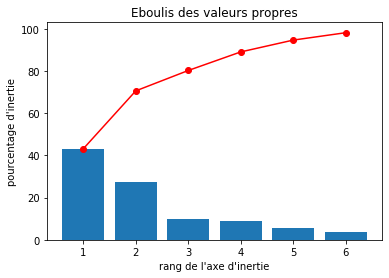

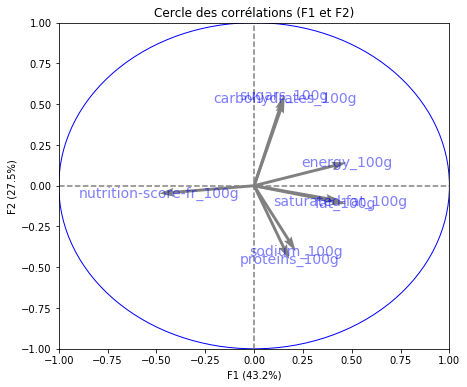

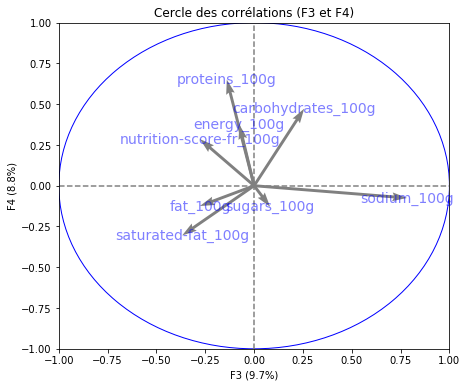

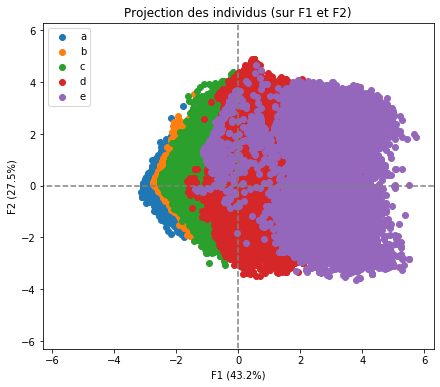

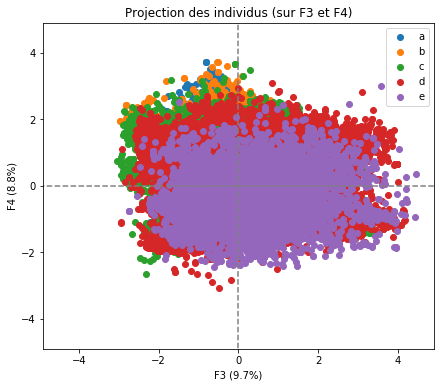

In [29]:
n_comp = 6

# préparation des données pour l'ACP
data_pca = data_pca.fillna(0)
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)],labels = np.array(features))

nutriscore = df_france_filtre["nutriscore_grade"] 
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = nutriscore)

plt.show()

En observant le diagramme des éboulis, je constate qu'à partir de la 3ème composante le taux d'information n'augmente plus beaucoup. Le critère de Kaiser confirme puisque  seules les 2 premières composantes sont supérieures à 12,5%  (100%/8 = 12,5%).
La première composante semble être composée principalement de la teneur en graisse et de la valeur énergétique.
La deuxième composante semble être composée principalement des variables glucide, sel et protéine.

Je recherche le nombre optimal de cluster en graphant l'évolution de l'inertie intraclasse de 1 cluster à 15 clusters.

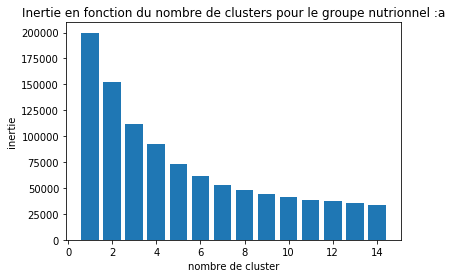

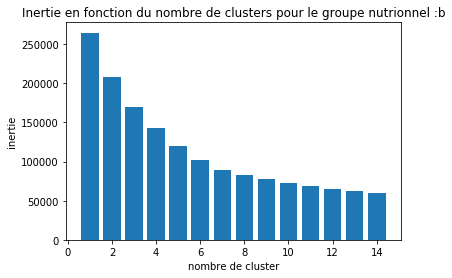

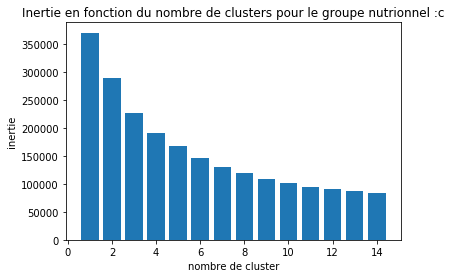

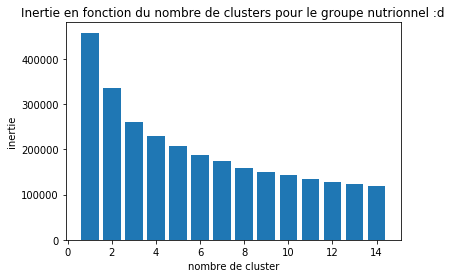

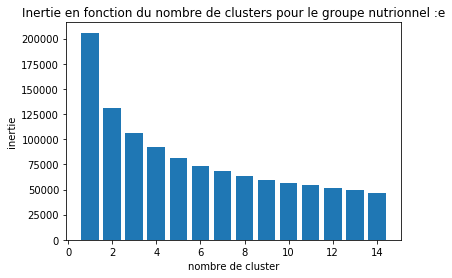

In [30]:
GroupeNutritionnel = df_france_filtre["nutriscore_grade"].sort_values().unique()

for Groupe in GroupeNutritionnel:
    inertieArray = []
    
    data_pca = df_france_filtre[["energy_100g",
                                    "saturated-fat_100g",
                                    "fat_100g",
                                    "sugars_100g",
                                    "carbohydrates_100g",
                                    "sodium_100g",
                                    "proteins_100g",
                                    "nutrition-score-fr_100g"
                                   ]][df_france_filtre["nutriscore_grade"]==Groupe]
    
    data_pca = data_pca.fillna(0)
    X = data_pca.values

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    for n_clust in range(1,15):
        # Clustering par K-means
        km = KMeans(n_clusters= n_clust)
        km.fit(X_scaled)
        inertieArray.append(km.inertia_)
        #print("Groupe nutritionnel :"+str(Groupe)+"/ itération :"+str(n_clust))
    
        inertieDataframe = pd.DataFrame(inertieArray,columns=['inertie'])

    plt.bar(range(1,15),inertieArray)
    plt.xlabel('nombre de cluster')
    plt.ylabel("inertie")
    plt.title('Inertie en fonction du nombre de clusters pour le groupe nutrionnel :'+str(Groupe))
    plt.show()
    


J'observe des coudes pour des valeurs différentes selon la catégorie nutritionnelle:
#-a : coude avec 6 clusters
#-b : coude avec 7 clusters
#-c : coude avec 7 clusters
#-d : coude avec 6 clusters
#-e : coude avec 4 clusters

Je réduit chaque sous-groupe nutritionnel au nombre de clusters défini précédemment :

In [31]:
n_clust = {}
n_clust['a'] = [6]
n_clust['b'] = [7]
n_clust['c'] = [7]
n_clust['d'] = [6]
n_clust['e'] = [4]

In [32]:
centroids_cluster =[]
df_centroids_cluster = pd.DataFrame()

GroupeNutritionnel = df_france_filtre["nutriscore_grade"].sort_values().unique()

inertie = 0

for Groupe in GroupeNutritionnel:
    data_pca = df_france_filtre[["energy_100g",
                                    "saturated-fat_100g",
                                    "fat_100g",
                                    "sugars_100g",
                                    "carbohydrates_100g",
                                    "sodium_100g",
                                    "proteins_100g",
                                    "nutrition-score-fr_100g"
                                   ]][df_france_filtre["nutriscore_grade"]==Groupe]
    
    data_pca = data_pca.fillna(0)
    X = data_pca.values

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    # Clustering par K-means
    km = KMeans(n_clusters= n_clust[Groupe][0])
    km.fit(X_scaled)

    # Création d'un DataFrame avec centroids des 3 clusters représentatifs du groupe nutritionnel
    centroids_cluster = pd.DataFrame(km.cluster_centers_,
                                     columns=data_pca.columns)
    
    #Ajout d'une colonne au DataFrame avec le groupe nutrionnel
    centroids_cluster["nutriscore_grade"] = Groupe
    
    #Ajout au DataFrame df_centroids_cluster qui contient tous les centroids créés 
    df_centroids_cluster = df_centroids_cluster.append(centroids_cluster)

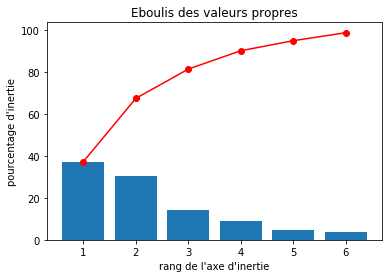

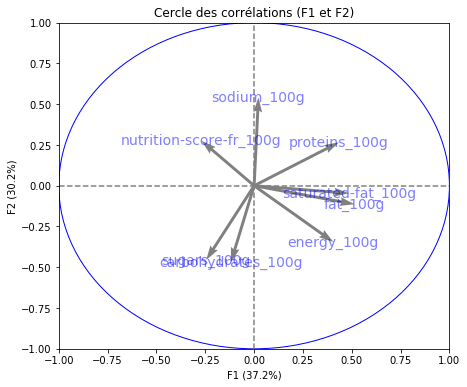

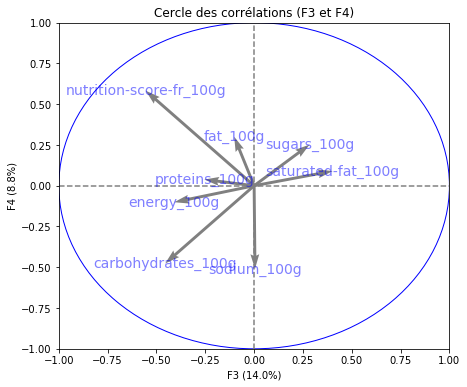

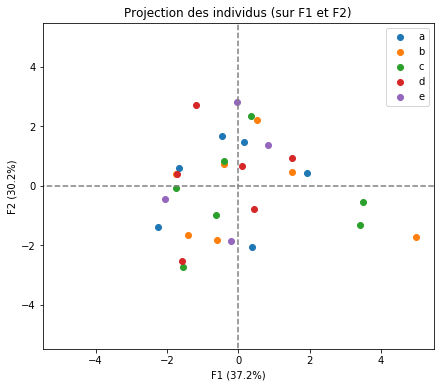

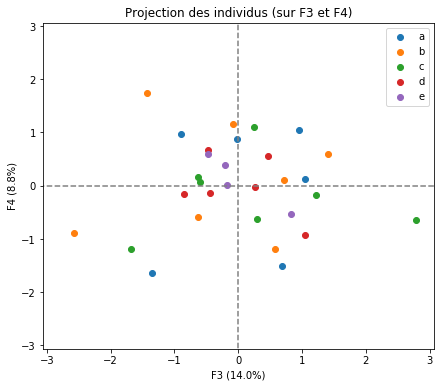

In [33]:
n_comp = 6

# préparation des données pour l'ACP
data_pca = df_centroids_cluster[[
    "energy_100g",
    "saturated-fat_100g",
    "fat_100g",
    "sugars_100g",
    "carbohydrates_100g",
    "sodium_100g",
    "proteins_100g",
    "nutrition-score-fr_100g"
]]

data_pca = data_pca.fillna(0)
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

nutriscore = df_centroids_cluster["nutriscore_grade"] 
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = nutriscore)

plt.show()

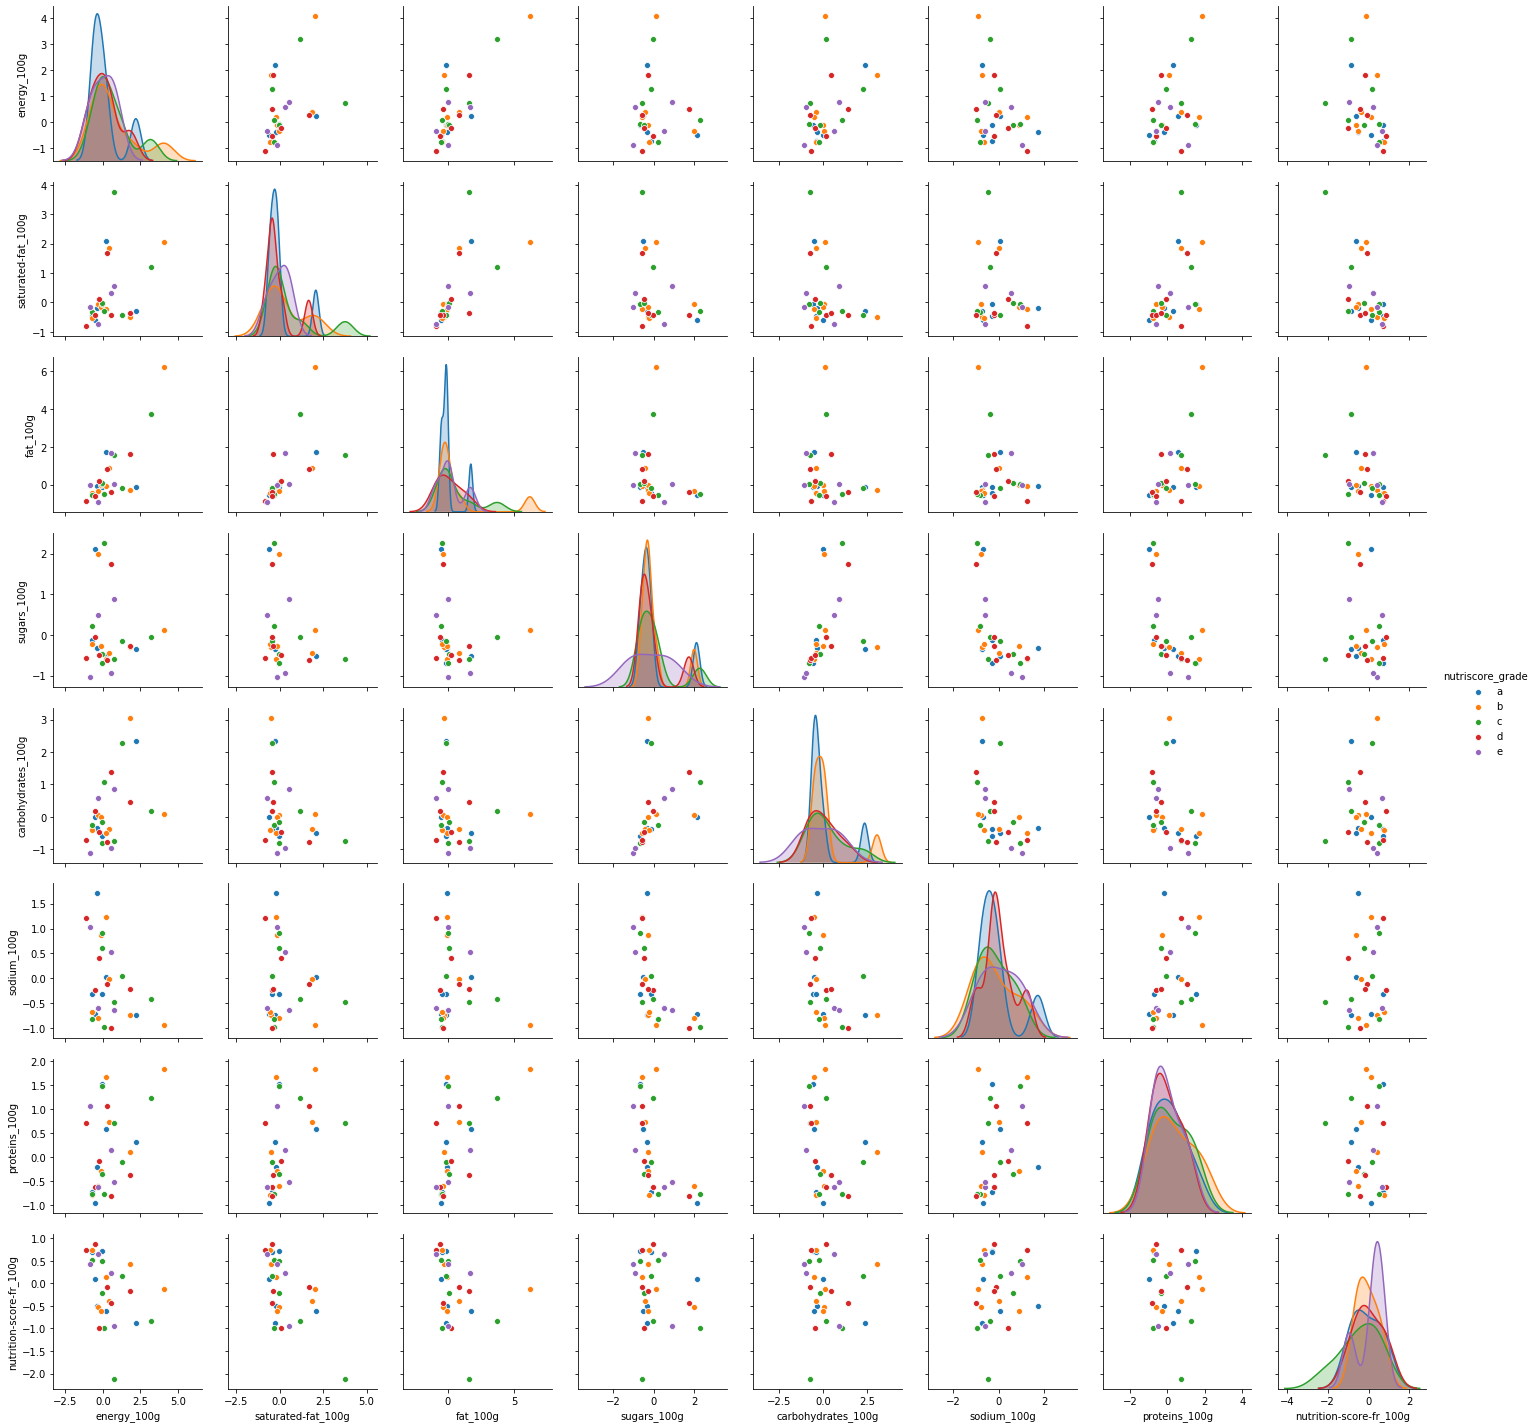

In [34]:
df_centroids_cluster_dna = df_centroids_cluster[[ 
    "energy_100g",
    "saturated-fat_100g",
    "fat_100g",
    "sugars_100g",
    "carbohydrates_100g",
    "sodium_100g",
    "proteins_100g",
    "nutriscore_grade",
    "nutrition-score-fr_100g"
]].fillna(0)

sns.pairplot(df_centroids_cluster_dna,hue="nutriscore_grade")
plt.show()

Je n'identifie pas de zones spécifiques se dégager pour une catégorie nutritionnelle particulière. Par ailleurs je me pose des questions concernant la qualité des données des colonnes nutriscore. Quand je regarde ci-dessus le graphique de sugar_100g vs fat_100g, les 3 clusters avec le plus de gras ont pour nutriscore A, B et C. Idem pour les 3 clusters avec le plus de sucre...

Je vais refaire le clustering en prenant le même nombre de clusters (10) pour chaque catégorie de nutriscore.

In [35]:
n_clust = {}
n_clust['a'] = [100]
n_clust['b'] = [100]
n_clust['c'] = [100]
n_clust['d'] = [100]
n_clust['e'] = [100]

In [36]:
centroids_cluster =[]
df_centroids_cluster = pd.DataFrame()

GroupeNutritionnel = df_france_filtre["nutriscore_grade"].sort_values().unique()

inertie = 0

for Groupe in GroupeNutritionnel:
    data_pca = df_france_filtre[["energy_100g",
                                    "saturated-fat_100g",
                                    "fat_100g",
                                    "sugars_100g",
                                    "carbohydrates_100g",
                                    "sodium_100g",
                                    "proteins_100g",
                                    "nutrition-score-fr_100g"
                                   ]][df_france_filtre["nutriscore_grade"]==Groupe]
    
    data_pca = data_pca.fillna(0)
    X = data_pca.values

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    # Clustering par K-means
    km = KMeans(n_clusters= n_clust[Groupe][0])
    km.fit(X_scaled)

    # Création d'un DataFrame avec centroids des 3 clusters représentatifs du groupe nutritionnel
    centroids_cluster = pd.DataFrame(km.cluster_centers_,columns=data_pca.columns)
    
    #Ajout d'une colonne au DataFrame avec le groupe nutrionnel
    centroids_cluster["nutriscore_grade"] = Groupe
    
    #Ajout au DataFrame df_centroids_cluster qui contient tous les centroids créés 
    df_centroids_cluster = df_centroids_cluster.append(centroids_cluster)

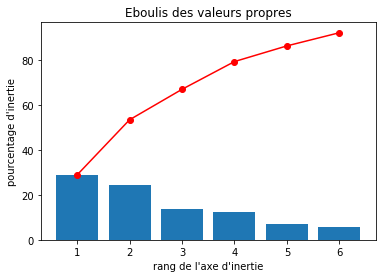

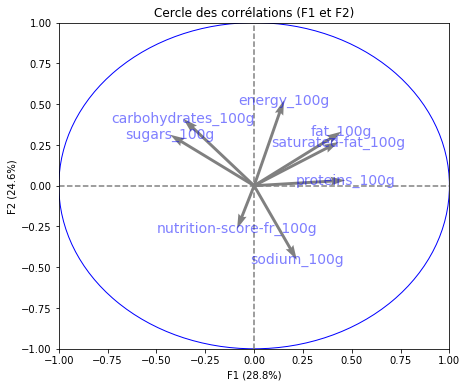

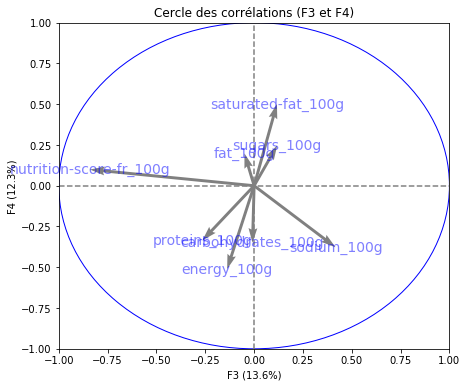

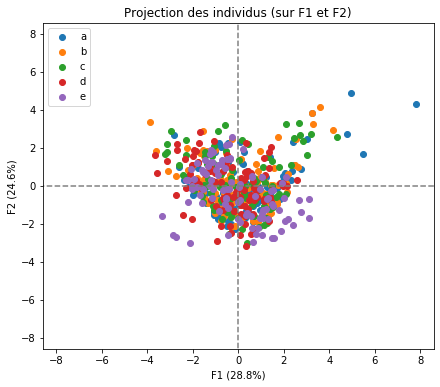

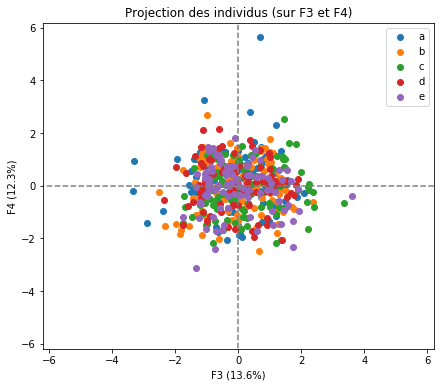

In [37]:
n_comp = 6

# préparation des données pour l'ACP
data_pca = df_centroids_cluster[["energy_100g",
                                 "saturated-fat_100g",
                                 "fat_100g",
                                 "sugars_100g",
                                 "carbohydrates_100g",
                                 "sodium_100g",
                                 "proteins_100g",
                                "nutrition-score-fr_100g"]]

data_pca = data_pca.fillna(0)
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

nutriscore = df_centroids_cluster["nutriscore_grade"] 
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = nutriscore)

plt.show()

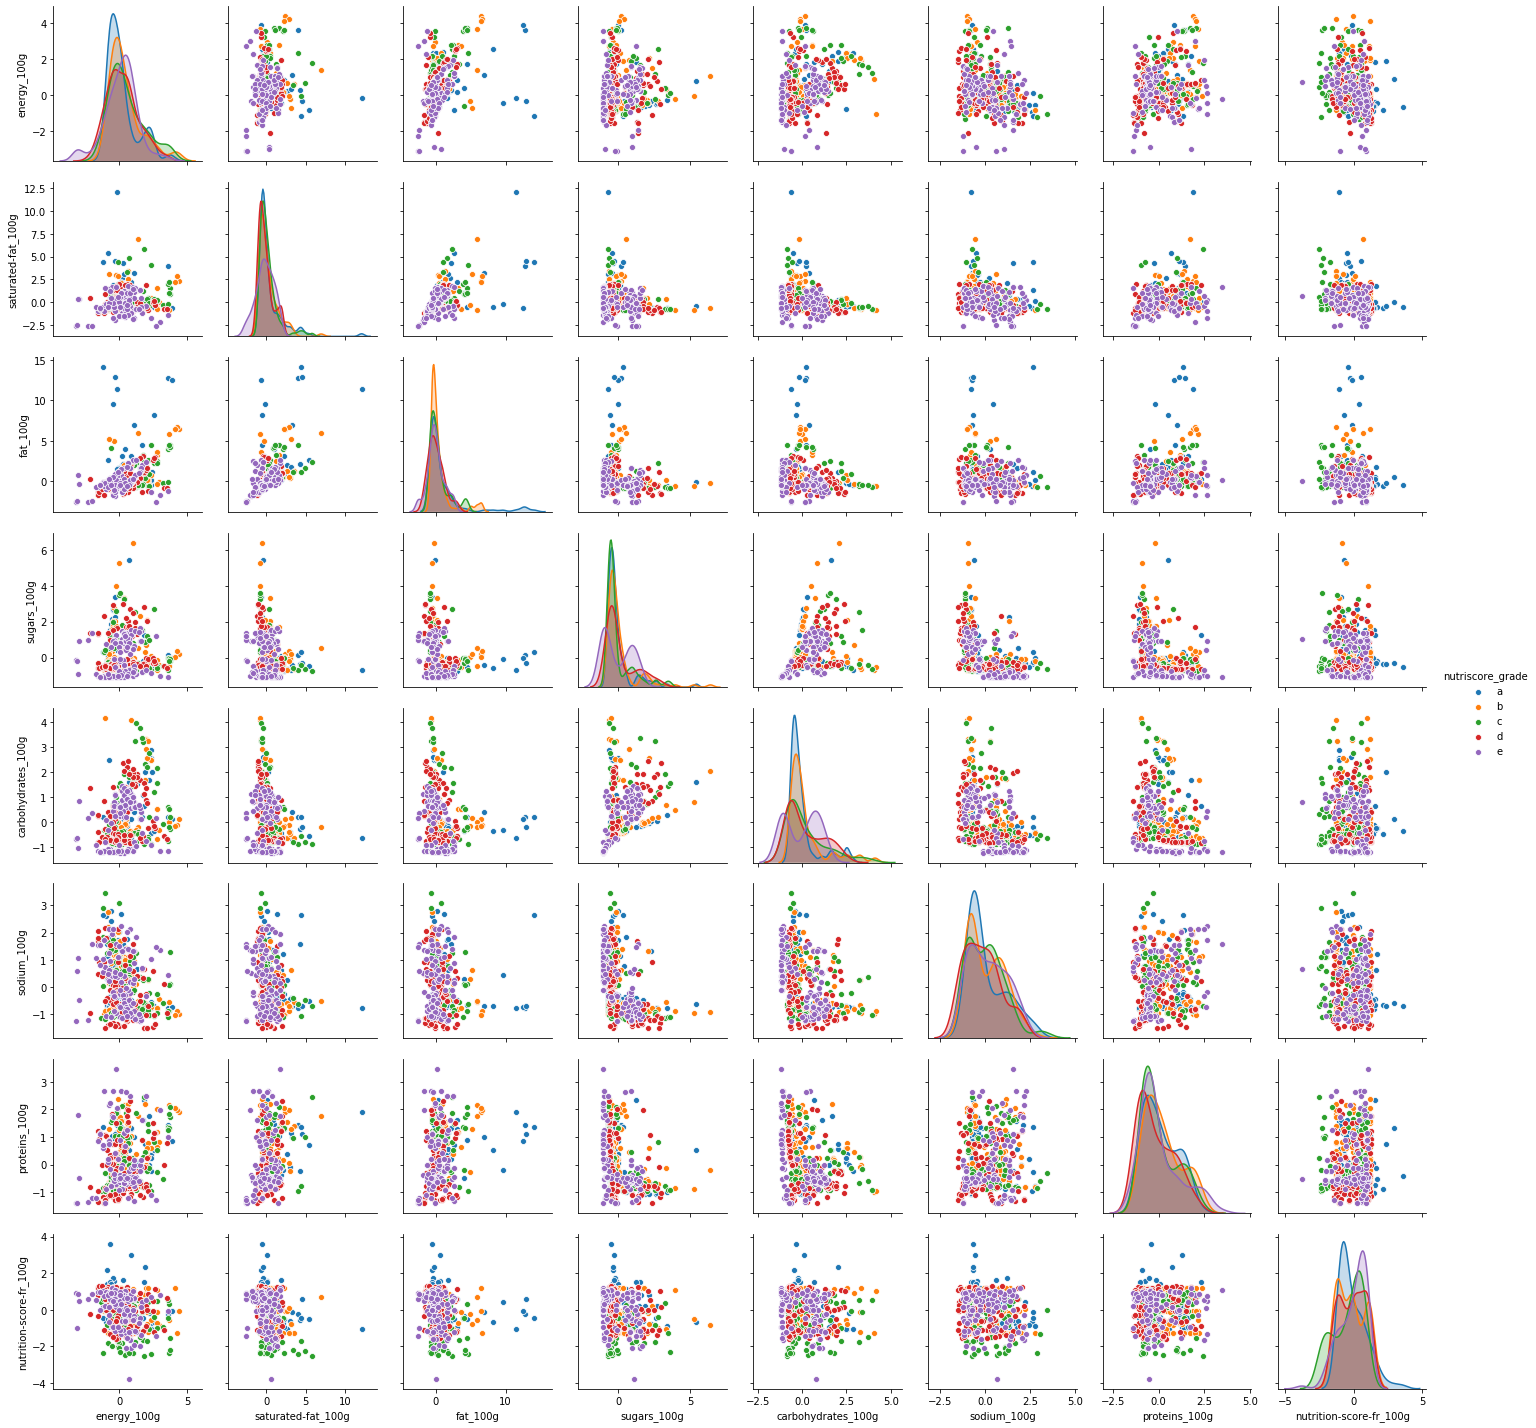

In [38]:
df_centroids_cluster_dna = df_centroids_cluster[[ 
    "energy_100g",
    "saturated-fat_100g",
    "fat_100g",
    "sugars_100g",
    "carbohydrates_100g",
    "sodium_100g",
    "proteins_100g",
    "nutriscore_grade",
    "nutrition-score-fr_100g"
]].fillna(0)

sns.pairplot(df_centroids_cluster_dna,hue="nutriscore_grade")
plt.show()

Je pensais que le nombre de cluster plus petit pour les catégories de nutriscore D et E avait pu induire un positionnement plus favorable de leurs centroids. Je constate que cela ne change rien à mon constat précédent. Ce sont des centroids A, B et C qui continuent à avoir le plus de gras et de sucre.

Les axes d'inertie principaux créés par l'ACP sont les suivants:
#-Le premier axe tend à être définit par la teneur en graisse et en protéine du produit
#-Le deuxième axe fait apparaître que la teneur en sucre et en sel sont anti-corrélées. C'est à dire que les produits sucrés ont tendance à ne pas être salés et inversement. Cela correspond aux goûts de la cuisine occidental où le sucré et le salé sont séparés. Si j'avais étudié les produits pour un pays asiatique le constat aurait certainement été différent.
#-Lorsque la teneur en sucre ou en graisse d'un produit augmente, l'energie contenue par celui-ci semble augmenter avec. C'est plutôt logique
#-Les produit gras et salés ont tendance à contenir plus de protéines que les produits sucrés.

Les 2 premiers axes principaux d'inertie totalisent plus de 53% de l'inertie. 

Compte tenu des résultats des analyses ci-dessus je revois mon concept d'application. Je vais chercher des clusters sur l'ensemble des produits non catégorisés par nurtiscore.

Je réalise un Kmeans pour réduire la taille du dataset à 100 individus.

In [39]:
data_pca = df_france_filtre[["energy_100g",
                                    "saturated-fat_100g",
                                    "fat_100g",
                                    "sugars_100g",
                                    "carbohydrates_100g",
                                    "sodium_100g",
                                    "proteins_100g",
                                    "nutrition-score-fr_100g"
                                   ]]
    
data_pca = data_pca.fillna(0)
X = data_pca.values

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering par K-means
km = KMeans(n_clusters= 100)
km.fit(X_scaled)

clusters_kmeans = km.labels_
centroids_after_kmeans = km.cluster_centers_

Je réalise une classification hiérarchique pour identifier le nombre de clusters à partir duquel la distance entre individus ne diminue plus beaucoup. 

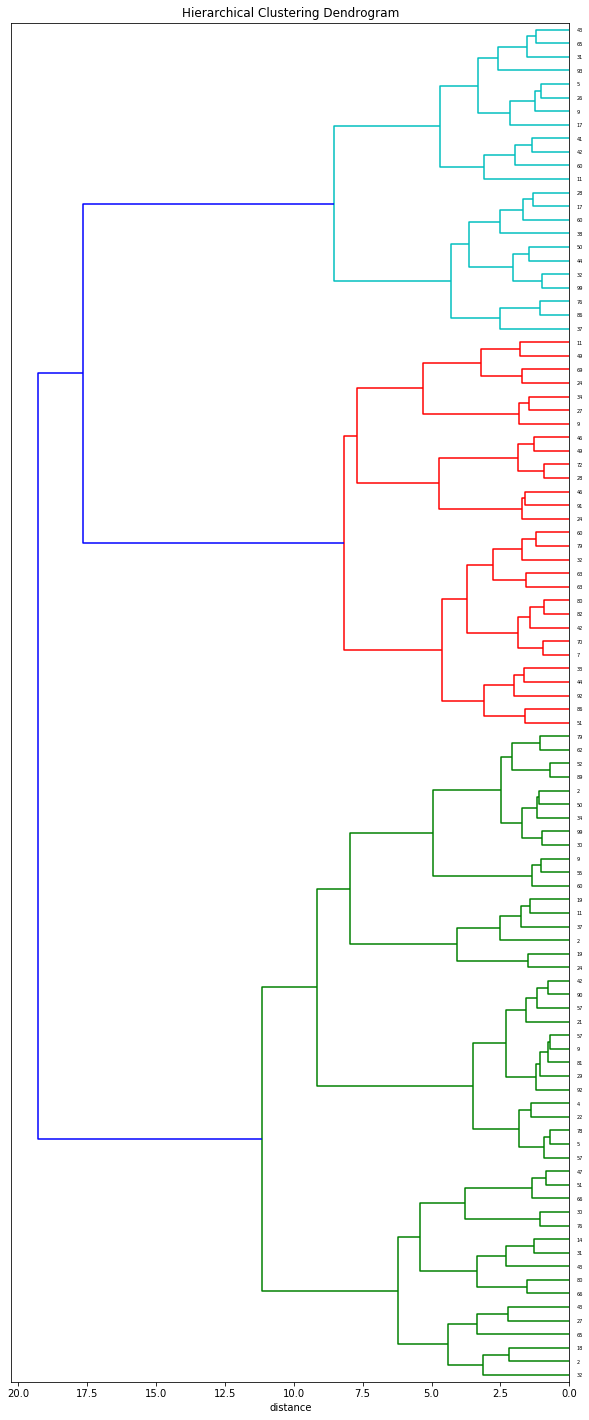

In [40]:
# Clustering hiérarchique
Z = linkage(centroids_after_kmeans, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names=clusters_kmeans)

Je remarque qu'à partir de 3 clusters, la distance entre individus ne diminue moins vite.

In [41]:
data_pca = df_france_filtre[["energy_100g",
                                "saturated-fat_100g",
                                "fat_100g",
                                "sugars_100g",
                                "carbohydrates_100g",
                                "sodium_100g",
                                "proteins_100g",
                                "nutrition-score-fr_100g"
                               ]]

data_pca = data_pca.fillna(0)
X = data_pca.values

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

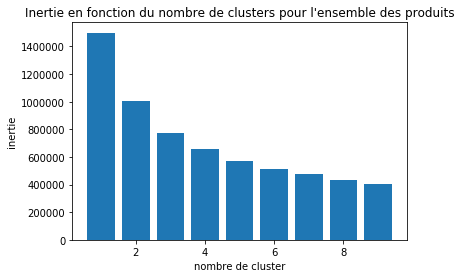

In [42]:
inertieArray = []

for n_clust in range(1,10):
    # Clustering par K-means
    km = KMeans(n_clusters= n_clust)
    km.fit(X_scaled)
    inertieArray.append(km.inertia_)
    #print("itération :"+str(n_clust))

    inertieDataframe = pd.DataFrame(inertieArray,columns=['inertie'])

plt.bar(range(1,10),inertieArray)
plt.xlabel('nombre de cluster')
plt.ylabel("inertie")
plt.title("Inertie en fonction du nombre de clusters pour l'ensemble des produits")
plt.show()


Le coude est à environ 3 clusters, cela confirme l'observation du dendrogramme.

In [46]:
# Nombre de clusters souhaités
n_clust = 3

# Clustering par K-means
km = KMeans(n_clusters= n_clust)
km.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [47]:
# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
n_comp=6
pca = decomposition.PCA(n_components=n_comp).fit(X_scaled)
X_projected = pca.transform(X_scaled)

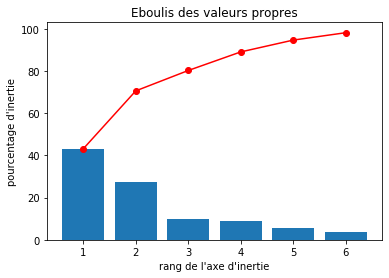

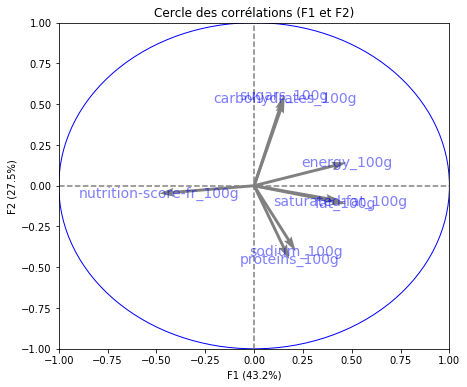

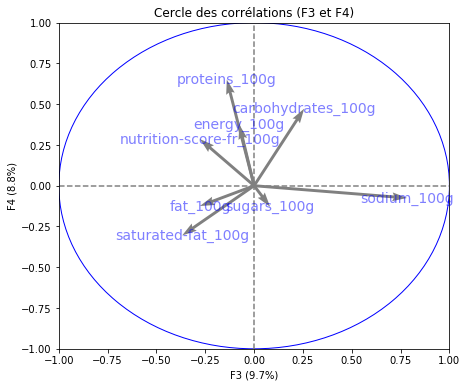

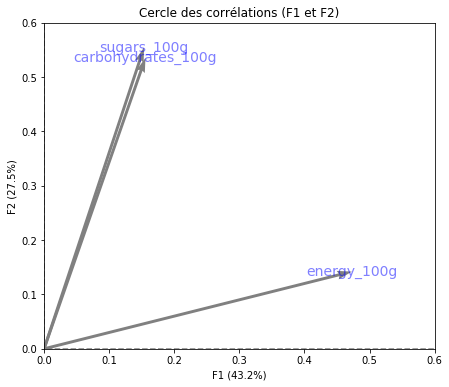

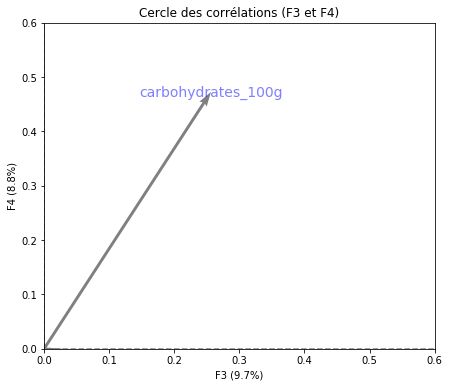

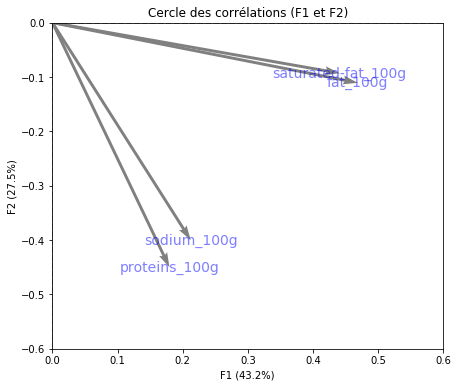

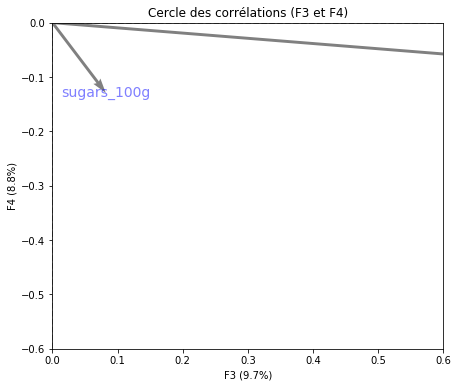

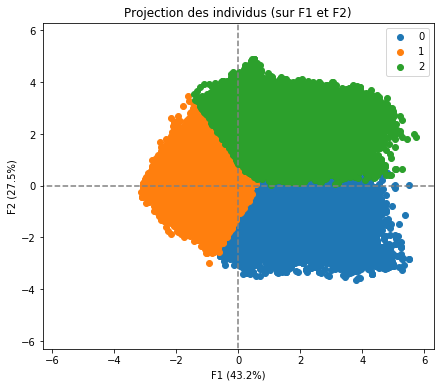

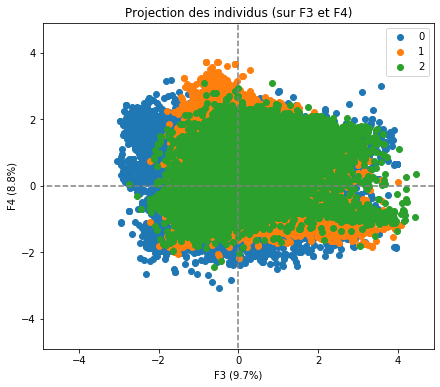

In [48]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
features = data_pca.columns
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(0,1),(2,3)],lims=[0,.6,0,0.6], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(0,1),(2,3)],lims=[0,.6,-.6,0], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = clusters )

plt.show()

J'obtiens un bon clustering des produits autours de 3 catégories. Les 2 premiers axes principaux d'inertie représentent 68% de l'inertie totale.

J'observe que la catégorie bleue (0) tend à représenter les produits gras et sucrés. La catégorie verte tend (2) tend à représenter les produits salés, protéinés et gras.
La catégorie orange (1) tend à représenter les produits avec une faible teneur en gras et pauvre en sel ou en sucre. Cette dernière catégorie est corrélée avec un bon score nutritionnel.

Je propose faire une application indiquant pour le produit scanné le positionnement de la teneur en sel/sucre/graisse par rapport aux moyennes de la catégorie alimentaire.